In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((400, 400)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform_2 img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, model):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.model_fe = nn.Sequential(*list(model.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=147456, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.model_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(model = models.densenet121(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 7543684


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


train loss:  1.0828941714746347
Val loss:  0.9444198442542034
train accuracy:  0.4622823984526112
Val accuracy:  0.4434782608695652
Best model at the moment with Val_acc 44.35, saving...
Current time: 6.632 minutes. Time expected till completion: 656.585 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.460817233736787
Val loss:  1.4483700910340185
train accuracy:  0.46131528046421666
Val accuracy:  0.4260869565217391
Current time: 8.651 minutes. Time expected till completion: 423.892 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.576659151960013
Val loss:  1.4926873393680737
train accuracy:  0.4796905222437137
Val accuracy:  0.5217391304347826
Best model at the moment with Val_acc 52.17, saving...
Current time: 10.653 minutes. Time expected till completion: 344.434 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.711641930389096
Val loss:  1.6612434402447316
train accuracy:  0.4864603481624758
Val accuracy:  0.5130434782608696
Current time: 12.644 minutes. Time expected till completion: 303.447 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.9987450369510564
Val loss:  1.756696018965348
train accuracy:  0.44390715667311414
Val accuracy:  0.5130434782608696
Current time: 14.630 minutes. Time expected till completion: 277.966 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  2.0151606180207113
Val loss:  3.1809480397597603
train accuracy:  0.46808510638297873
Val accuracy:  0.4434782608695652
Current time: 16.617 minutes. Time expected till completion: 260.336 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  2.1048752672437083
Val loss:  5.200969926170681
train accuracy:  0.44777562862669246
Val accuracy:  0.4260869565217391
Current time: 18.606 minutes. Time expected till completion: 247.197 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.1253448786318474
Val loss:  7.7210410252861355
train accuracy:  0.4574468085106383
Val accuracy:  0.5478260869565217
Best model at the moment with Val_acc 54.78, saving...
Current time: 20.600 minutes. Time expected till completion: 236.900 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.9139999115093822
Val loss:  5.768016073755596
train accuracy:  0.4758220502901354
Val accuracy:  0.43478260869565216
Current time: 22.587 minutes. Time expected till completion: 228.383 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.3154151967404197
Val loss:  33.53304801816525
train accuracy:  0.4738878143133462
Val accuracy:  0.4956521739130435
Current time: 24.574 minutes. Time expected till completion: 221.163 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  2.085220845052306
Val loss:  171.17999166405718
train accuracy:  0.4709864603481625
Val accuracy:  0.3217391304347826
Current time: 26.562 minutes. Time expected till completion: 214.914 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.4366872580992185
Val loss:  5.355186796188354
train accuracy:  0.4410058027079304
Val accuracy:  0.4260869565217391
Current time: 28.549 minutes. Time expected till completion: 209.357 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  2.6825330241851697
Val loss:  2.6650146650231403
train accuracy:  0.4661508704061896
Val accuracy:  0.19130434782608696
Current time: 30.539 minutes. Time expected till completion: 204.376 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.4936059266581005
Val loss:  3.924669599533081
train accuracy:  0.4632495164410058
Val accuracy:  0.40869565217391307
Current time: 32.526 minutes. Time expected till completion: 199.803 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  2.1381494514716204
Val loss:  1.5141690544055209
train accuracy:  0.437137330754352
Val accuracy:  0.40869565217391307
Current time: 34.514 minutes. Time expected till completion: 195.582 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.019889053036558
Val loss:  17.41193907260895
train accuracy:  0.4671179883945841
Val accuracy:  0.4434782608695652
Current time: 36.504 minutes. Time expected till completion: 191.645 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.120180865090405
Val loss:  1.2408938860878824
train accuracy:  0.4748549323017408
Val accuracy:  0.4782608695652174
Current time: 38.492 minutes. Time expected till completion: 187.929 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.18892423373357
Val loss:  3.2639879158951097
train accuracy:  0.4816247582205029
Val accuracy:  0.4260869565217391
Current time: 40.476 minutes. Time expected till completion: 184.390 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.3111178661539893
Val loss:  5.759782569693482
train accuracy:  0.4497098646034816
Val accuracy:  0.4
Current time: 42.463 minutes. Time expected till completion: 181.027 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  2.0122602673632954
Val loss:  0.3468231703924096
train accuracy:  0.48065764023210833
Val accuracy:  0.3652173913043478
Current time: 44.454 minutes. Time expected till completion: 177.816 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.253321918458957
Val loss:  3.0439274995223338
train accuracy:  0.44294003868471954
Val accuracy:  0.4
Current time: 46.442 minutes. Time expected till completion: 174.711 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  2.421012899343004
Val loss:  0.8624320480910525
train accuracy:  0.4622823984526112
Val accuracy:  0.41739130434782606
Current time: 48.433 minutes. Time expected till completion: 171.717 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.9264496057015092
Val loss:  0.8167405479142199
train accuracy:  0.43520309477756286
Val accuracy:  0.4608695652173913
Current time: 50.427 minutes. Time expected till completion: 168.822 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.6534718331129685
Val loss:  3.0972494736961695
train accuracy:  0.43133462282398455
Val accuracy:  0.5217391304347826
Current time: 52.415 minutes. Time expected till completion: 165.980 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.6098404484053415
Val loss:  0.4480224018511565
train accuracy:  0.4661508704061896
Val accuracy:  0.4782608695652174
Current time: 54.407 minutes. Time expected till completion: 163.220 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.747856188097129
Val loss:  5.539233696979025
train accuracy:  0.4284332688588008
Val accuracy:  0.5130434782608696
Current time: 56.412 minutes. Time expected till completion: 160.558 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.556750507574939
Val loss:  36.550748559702996
train accuracy:  0.45551257253384914
Val accuracy:  0.3652173913043478
Current time: 58.415 minutes. Time expected till completion: 157.936 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


train loss:  2.101529268097543
Val loss:  2.765710899104243
train accuracy:  0.47195357833655704
Val accuracy:  0.40869565217391307
Current time: 60.411 minutes. Time expected till completion: 155.342 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.538901667645637
Val loss:  0.9845900452655295
train accuracy:  0.44777562862669246
Val accuracy:  0.40869565217391307
Current time: 62.403 minutes. Time expected till completion: 152.780 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  2.5055294770682575
Val loss:  13.919211893496305
train accuracy:  0.4816247582205029
Val accuracy:  0.3739130434782609
Current time: 64.463 minutes. Time expected till completion: 150.414 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  2.125537317613684
Val loss:  4.29847528208857
train accuracy:  0.49032882011605416
Val accuracy:  0.4434782608695652
Current time: 66.462 minutes. Time expected till completion: 147.931 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.8899086368210771
Val loss:  3.8279337261034097
train accuracy:  0.488394584139265
Val accuracy:  0.4
Current time: 68.463 minutes. Time expected till completion: 145.484 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  2.3529582024224074
Val loss:  25.105381689900938
train accuracy:  0.47195357833655704
Val accuracy:  0.48695652173913045
Current time: 70.470 minutes. Time expected till completion: 143.075 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  2.418746141273694
Val loss:  2.8524551474529765
train accuracy:  0.488394584139265
Val accuracy:  0.40869565217391307
Current time: 72.472 minutes. Time expected till completion: 140.681 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


train loss:  2.6735375390984335
Val loss:  11.009516518060927
train accuracy:  0.47292069632495165
Val accuracy:  0.45217391304347826
Current time: 74.498 minutes. Time expected till completion: 138.353 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  2.4569976974271484
Val loss:  12.128488509551339
train accuracy:  0.4816247582205029
Val accuracy:  0.4260869565217391
Current time: 76.540 minutes. Time expected till completion: 136.072 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  2.235437124304661
Val loss:  23.750731982873834
train accuracy:  0.46518375241779497
Val accuracy:  0.48695652173913045
Current time: 78.547 minutes. Time expected till completion: 133.743 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  2.24905214974264
Val loss:  22.440399762599366
train accuracy:  0.48065764023210833
Val accuracy:  0.3739130434782609
Current time: 80.544 minutes. Time expected till completion: 131.415 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  2.2502810805171323
Val loss:  0.6173374168250871
train accuracy:  0.4458413926499033
Val accuracy:  0.45217391304347826
Current time: 82.540 minutes. Time expected till completion: 129.102 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  2.0760215754608122
Val loss:  5.612624483523161
train accuracy:  0.46421663442940037
Val accuracy:  0.45217391304347826
Current time: 84.553 minutes. Time expected till completion: 126.830 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  2.161666001122971
Val loss:  1.970796540508886
train accuracy:  0.4564796905222437
Val accuracy:  0.4434782608695652
Current time: 86.566 minutes. Time expected till completion: 124.571 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


train loss:  2.1154082103252296
Val loss:  2.3651667506798453
train accuracy:  0.4738878143133462
Val accuracy:  0.4782608695652174
Current time: 88.570 minutes. Time expected till completion: 122.311 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


train loss:  1.9855207491313005
Val loss:  21.942185176262864
train accuracy:  0.48936170212765956
Val accuracy:  0.48695652173913045
Current time: 90.571 minutes. Time expected till completion: 120.059 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


train loss:  2.1144608385507735
Val loss:  1.07924369107122
train accuracy:  0.48936170212765956
Val accuracy:  0.33043478260869563
Current time: 92.567 minutes. Time expected till completion: 117.812 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  1.8618623225353441
Val loss:  75.30273062249888
train accuracy:  0.4922630560928433
Val accuracy:  0.48695652173913045
Current time: 94.568 minutes. Time expected till completion: 115.583 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  1.8798831505430735
Val loss:  21.37851512743079
train accuracy:  0.5077369439071566
Val accuracy:  0.40869565217391307
Current time: 96.586 minutes. Time expected till completion: 113.384 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


train loss:  1.8158126717552225
Val loss:  3582.265464291365
train accuracy:  0.4816247582205029
Val accuracy:  0.45217391304347826
Current time: 98.627 minutes. Time expected till completion: 111.217 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  1.8955102796212373
Val loss:  30.686567530165547
train accuracy:  0.46131528046421666
Val accuracy:  0.40869565217391307
Current time: 100.655 minutes. Time expected till completion: 109.043 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  1.8781210377351227
Val loss:  8.007876564367958
train accuracy:  0.45164410058027077
Val accuracy:  0.5391304347826087
Current time: 102.664 minutes. Time expected till completion: 106.854 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  1.6782418282511617
Val loss:  0.550172467853712
train accuracy:  0.4796905222437137
Val accuracy:  0.5043478260869565
Current time: 104.702 minutes. Time expected till completion: 104.702 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  1.8871690897375517
Val loss:  10.838755229352365
train accuracy:  0.4738878143133462
Val accuracy:  0.4782608695652174
Current time: 106.725 minutes. Time expected till completion: 102.540 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.948872614587068
Val loss:  43.593906585029934
train accuracy:  0.46808510638297873
Val accuracy:  0.23478260869565218
Current time: 108.721 minutes. Time expected till completion: 100.358 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.9000092886921516
Val loss:  15.752774473591506
train accuracy:  0.47775628626692457
Val accuracy:  0.4608695652173913
Current time: 110.716 minutes. Time expected till completion: 98.183 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  1.9895164918161683
Val loss:  12.435239937771922
train accuracy:  0.4941972920696325
Val accuracy:  0.4434782608695652
Current time: 112.712 minutes. Time expected till completion: 96.014 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


train loss:  1.7487014298339878
Val loss:  1.9850325563679572
train accuracy:  0.5067698259187621
Val accuracy:  0.4434782608695652
Current time: 114.712 minutes. Time expected till completion: 93.855 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


train loss:  1.9860092070047353
Val loss:  0.9021738923113825
train accuracy:  0.4990328820116054
Val accuracy:  0.4608695652173913
Current time: 116.739 minutes. Time expected till completion: 91.724 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


train loss:  1.6542228513921484
Val loss:  7.236094400157099
train accuracy:  0.511605415860735
Val accuracy:  0.24347826086956523
Current time: 118.773 minutes. Time expected till completion: 89.601 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  1.6291811882988396
Val loss:  42.70561176797618
train accuracy:  0.48549323017408125
Val accuracy:  0.4782608695652174
Current time: 120.764 minutes. Time expected till completion: 87.450 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


train loss:  1.6551946354399452
Val loss:  9.552525586213754
train accuracy:  0.504835589941973
Val accuracy:  0.5391304347826087
Current time: 122.777 minutes. Time expected till completion: 85.320 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  1.7532057090485882
Val loss:  3498.588236073113
train accuracy:  0.5145067698259188
Val accuracy:  0.5043478260869565
Current time: 124.786 minutes. Time expected till completion: 83.191 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


train loss:  1.6806067129888895
Val loss:  23.72011003934819
train accuracy:  0.5290135396518375
Val accuracy:  0.5565217391304348
Best model at the moment with Val_acc 55.65, saving...
Current time: 126.833 minutes. Time expected till completion: 81.090 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  1.8268782741298297
Val loss:  1277.7307998035265
train accuracy:  0.5029013539651838
Val accuracy:  0.34782608695652173
Current time: 128.844 minutes. Time expected till completion: 78.969 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.144718813978323
Val loss:  5.352757636607756
train accuracy:  0.43520309477756286
Val accuracy:  0.4434782608695652
Current time: 130.853 minutes. Time expected till completion: 76.850 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.2178188344388046
Val loss:  2.7948675072711446
train accuracy:  0.44390715667311414
Val accuracy:  0.4260869565217391
Current time: 132.841 minutes. Time expected till completion: 74.723 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.03776126223791
Val loss:  4.822863591235617
train accuracy:  0.46518375241779497
Val accuracy:  0.3739130434782609
Current time: 134.829 minutes. Time expected till completion: 72.600 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.779435037010182
Val loss:  5.572326796987783
train accuracy:  0.46131528046421666
Val accuracy:  0.4
Current time: 136.816 minutes. Time expected till completion: 70.481 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  1.895473802826102
Val loss:  6.494487741719121
train accuracy:  0.46808510638297873
Val accuracy:  0.3652173913043478
Current time: 138.805 minutes. Time expected till completion: 68.367 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.927007355761482
Val loss:  3.601936087401017
train accuracy:  0.46518375241779497
Val accuracy:  0.4434782608695652
Current time: 140.793 minutes. Time expected till completion: 66.256 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.6288324613304273
Val loss:  2.635071024687394
train accuracy:  0.48936170212765956
Val accuracy:  0.391304347826087
Current time: 142.779 minutes. Time expected till completion: 64.147 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  1.6465544643554282
Val loss:  9.37868474048117
train accuracy:  0.49806576402321084
Val accuracy:  0.4
Current time: 144.764 minutes. Time expected till completion: 62.042 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.684171536249222
Val loss:  5.764887354684912
train accuracy:  0.45357833655706
Val accuracy:  0.4434782608695652
Current time: 146.753 minutes. Time expected till completion: 59.941 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.5606397523524913
Val loss:  7.211777778293776
train accuracy:  0.47292069632495165
Val accuracy:  0.3826086956521739
Current time: 148.740 minutes. Time expected till completion: 57.844 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.7611882485867238
Val loss:  5.935169710490205
train accuracy:  0.44874274661508706
Val accuracy:  0.3826086956521739
Current time: 150.727 minutes. Time expected till completion: 55.749 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.9172865391728726
Val loss:  4.030026384021925
train accuracy:  0.4526112185686654
Val accuracy:  0.45217391304347826
Current time: 152.715 minutes. Time expected till completion: 53.656 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.0691107700018634
Val loss:  3.1616907244143277
train accuracy:  0.4671179883945841
Val accuracy:  0.48695652173913045
Current time: 154.704 minutes. Time expected till completion: 51.568 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  1.9939647200832602
Val loss:  7.21427572633775
train accuracy:  0.4758220502901354
Val accuracy:  0.4434782608695652
Current time: 156.699 minutes. Time expected till completion: 49.484 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.8241838183347676
Val loss:  2.7802351370453833
train accuracy:  0.45938104448742745
Val accuracy:  0.45217391304347826
Current time: 158.685 minutes. Time expected till completion: 47.400 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.62202397663312
Val loss:  2.6428524061389593
train accuracy:  0.47775628626692457
Val accuracy:  0.3826086956521739
Current time: 160.689 minutes. Time expected till completion: 45.323 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.6120583171626586
Val loss:  2.664695092906123
train accuracy:  0.47678916827852996
Val accuracy:  0.45217391304347826
Current time: 162.713 minutes. Time expected till completion: 43.253 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  1.5897235908911238
Val loss:  1.4295911875431953
train accuracy:  0.5125725338491296
Val accuracy:  0.5043478260869565
Current time: 164.722 minutes. Time expected till completion: 41.180 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  1.5386390285404323
Val loss:  40.93368232146553
train accuracy:  0.47775628626692457
Val accuracy:  0.4260869565217391
Current time: 166.722 minutes. Time expected till completion: 39.108 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.6143643695075691
Val loss:  1.858186033497686
train accuracy:  0.5
Val accuracy:  0.5739130434782609
Best model at the moment with Val_acc 57.39, saving...
Current time: 168.727 minutes. Time expected till completion: 37.038 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.5915167742125993
Val loss:  2.543561199437017
train accuracy:  0.46808510638297873
Val accuracy:  0.4434782608695652
Current time: 170.723 minutes. Time expected till completion: 34.967 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.413610623353224
Val loss:  2.6258210596830946
train accuracy:  0.49709864603481624
Val accuracy:  0.43478260869565216
Current time: 172.716 minutes. Time expected till completion: 32.898 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.6133224009317788
Val loss:  2.0764036427373473
train accuracy:  0.48549323017408125
Val accuracy:  0.5043478260869565
Current time: 174.748 minutes. Time expected till completion: 30.838 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.2366931248074344
Val loss:  3.569116145386563
train accuracy:  0.504835589941973
Val accuracy:  0.4434782608695652
Current time: 176.763 minutes. Time expected till completion: 28.775 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  1.3151573356555333
Val loss:  4.595353611655857
train accuracy:  0.5125725338491296
Val accuracy:  0.4608695652173913
Current time: 178.751 minutes. Time expected till completion: 26.710 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.3910284631644538
Val loss:  2.147905298885282
train accuracy:  0.5241779497098646
Val accuracy:  0.3826086956521739
Current time: 180.738 minutes. Time expected till completion: 24.646 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.6839456680434355
Val loss:  3.856527708924335
train accuracy:  0.49709864603481624
Val accuracy:  0.40869565217391307
Current time: 182.724 minutes. Time expected till completion: 22.584 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.5437538415568248
Val loss:  1.1105227874672932
train accuracy:  0.4951644100580271
Val accuracy:  0.4956521739130435
Current time: 184.713 minutes. Time expected till completion: 20.524 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  1.5966456173928147
Val loss:  2.241386292291724
train accuracy:  0.4825918762088975
Val accuracy:  0.48695652173913045
Current time: 186.700 minutes. Time expected till completion: 18.465 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.3752771089775795
Val loss:  2.3290310634806266
train accuracy:  0.5125725338491296
Val accuracy:  0.4434782608695652
Current time: 188.690 minutes. Time expected till completion: 16.408 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.3465627949411045
Val loss:  4.881691045346467
train accuracy:  0.5377176015473888
Val accuracy:  0.4434782608695652
Current time: 190.676 minutes. Time expected till completion: 14.352 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.44909919260837
Val loss:  1.8799885096757307
train accuracy:  0.49032882011605416
Val accuracy:  0.5304347826086957
Current time: 192.664 minutes. Time expected till completion: 12.298 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.4645056334077389
Val loss:  1.9023052521373915
train accuracy:  0.5106382978723404
Val accuracy:  0.5217391304347826
Current time: 194.651 minutes. Time expected till completion: 10.245 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.2176372246596985
Val loss:  4.66990935131705
train accuracy:  0.5029013539651838
Val accuracy:  0.4782608695652174
Current time: 196.637 minutes. Time expected till completion: 8.193 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  1.4682781147073443
Val loss:  6.804801285785177
train accuracy:  0.5019342359767892
Val accuracy:  0.43478260869565216
Current time: 198.623 minutes. Time expected till completion: 6.143 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.519289101605489
Val loss:  29.8669153743464
train accuracy:  0.49709864603481624
Val accuracy:  0.46956521739130436
Current time: 200.608 minutes. Time expected till completion: 4.094 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.4745454708000778
Val loss:  3.3733645321691217
train accuracy:  0.5009671179883946
Val accuracy:  0.46956521739130436
Current time: 202.596 minutes. Time expected till completion: 2.046 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.366142224044876
Val loss:  1.6289391932280168
train accuracy:  0.5096711798839458
Val accuracy:  0.4608695652173913
Saving model 2 checkpoint


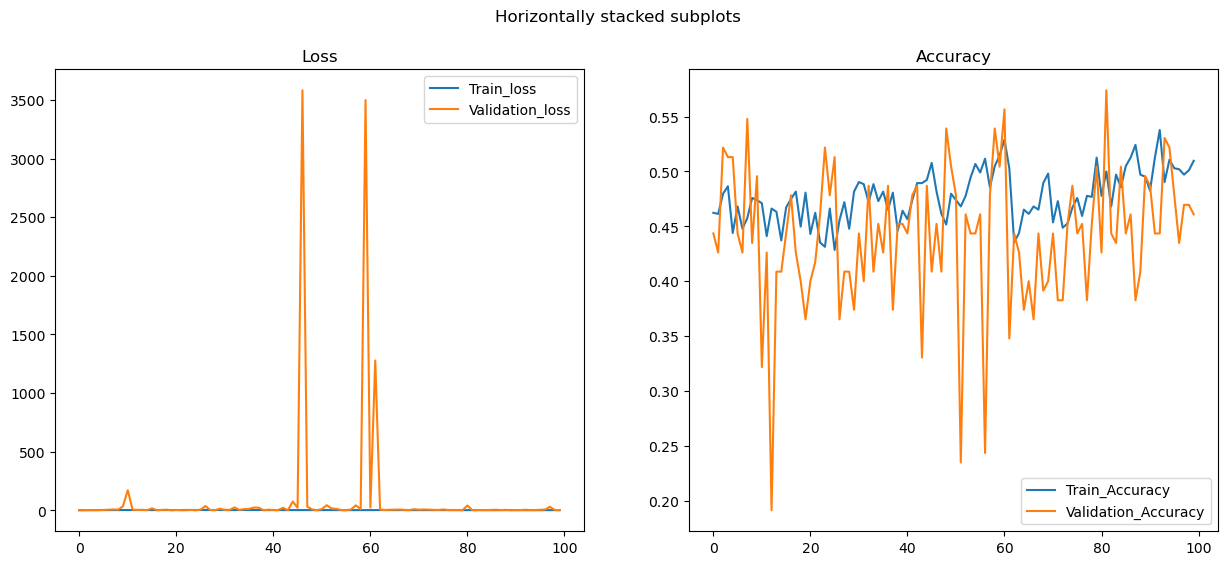

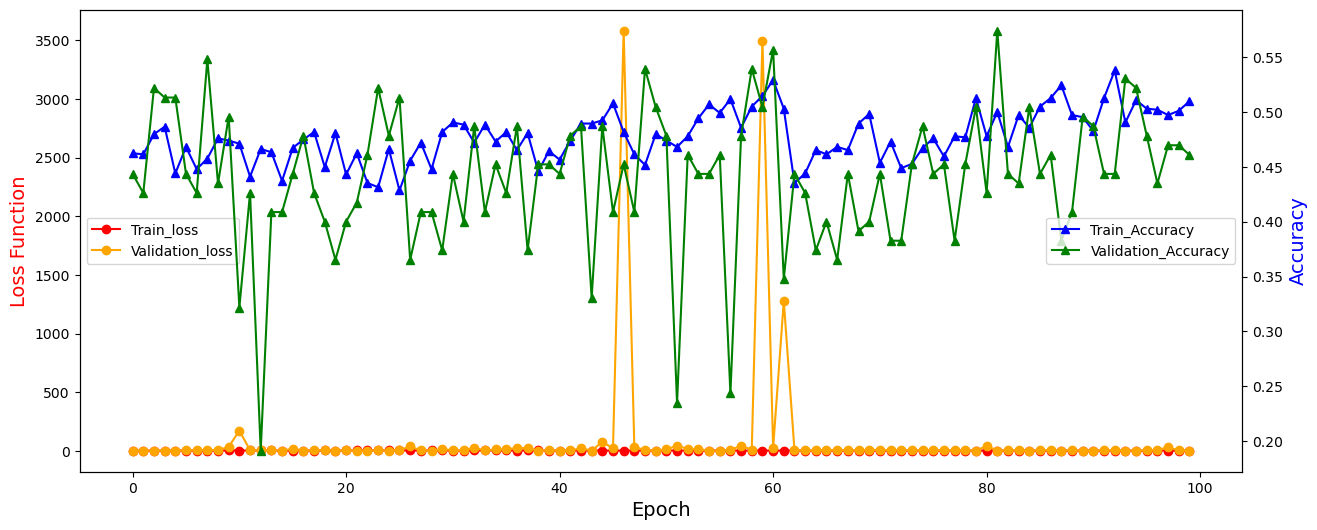

Current time: 204.905 minutes. Time expected till completion: 0.000 minutes
Finished training in: 204.906 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.5739130434782609

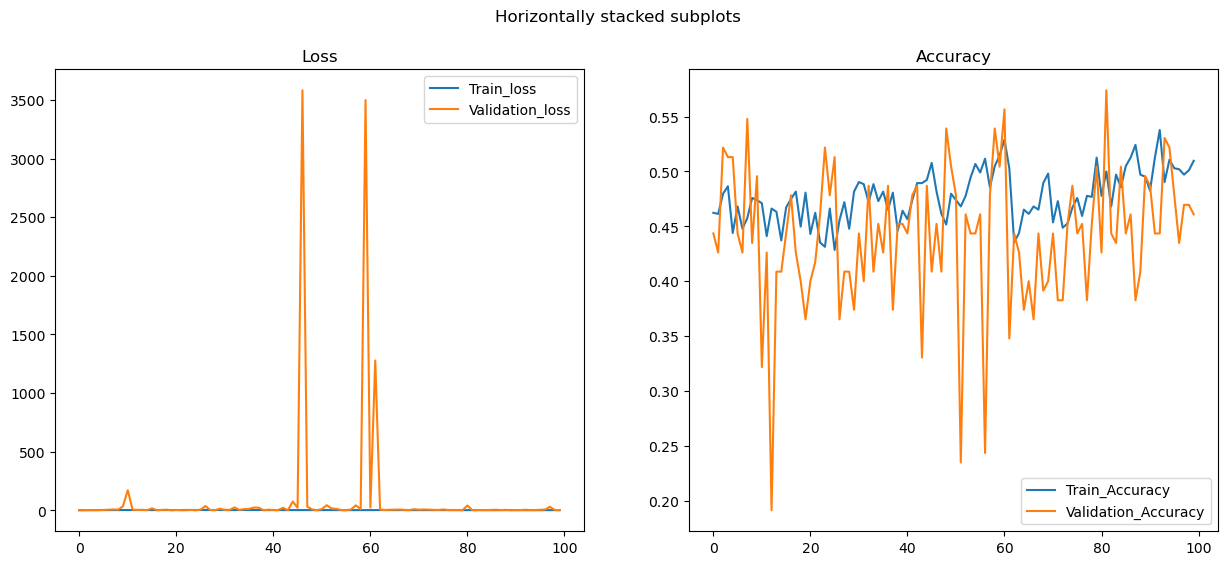

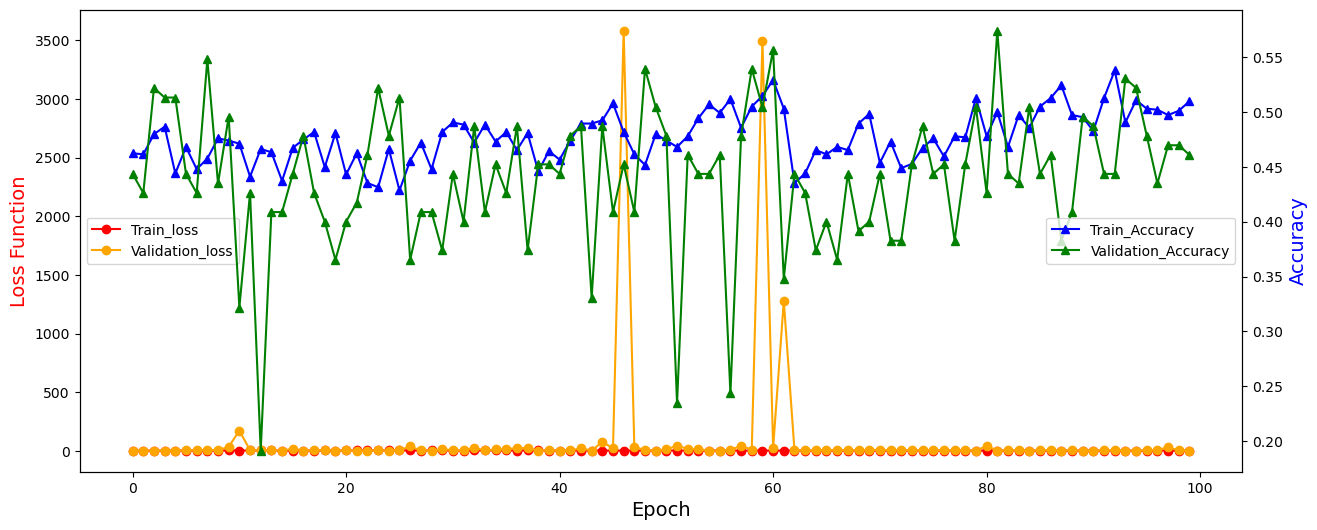

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:38<00:00,  3.34it/s]


Accuracy of the network on the 1034 Train instances: 47.48549323017408%


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

Accuracy of the network on the 115 Validation instances: 46.08695652173913%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:21<00:00, 17.42it/s]


(array([0, 1, 2, 3]), array([182,  17, 178,   3], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_DenseNet_prediction.csv")

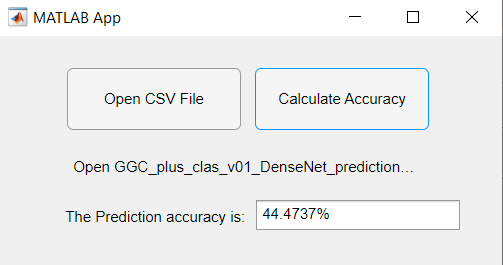

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:38<00:00,  3.34it/s]


Accuracy of the network on the 1034 Train instances: 49.516441005802704%


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

Accuracy of the network on the 115 Validation instances: 57.391304347826086%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:18<00:00, 20.31it/s]


(array([0, 1, 2, 3]), array([189,  61, 124,   6], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_DenseNet_best_prediction.csv")

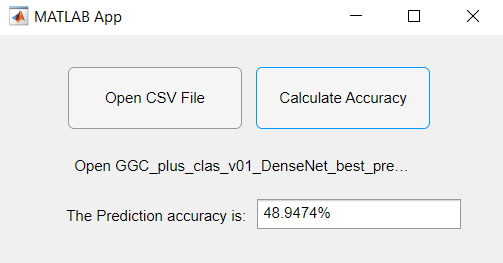